In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ============================================================
# KAGGLE UNIVERSAL CLASSIFICATION PIPELINE (SMALL DATA)
# Train + Test given | Any number of classes
# Probability-based submission | ID handled correctly
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [3]:

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
train = pd.read_csv("/Users/vedanshagarwal/Downloads/kaggle/trainprob.csv")
test  = pd.read_csv("/Users/vedanshagarwal/Downloads/kaggle/testprob.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (15000, 20)
Test shape : (10000, 19)


In [4]:

# ------------------------------------------------------------
# 2. HANDLE ID COLUMN (KAGGLE STYLE)
# ------------------------------------------------------------
id_col = "id"  # change only if dataset uses different name

train_ids = train[id_col]
test_ids  = test[id_col]

train.drop(columns=[id_col], inplace=True)
test.drop(columns=[id_col], inplace=True)

In [5]:

# ------------------------------------------------------------
# 3. IDENTIFY TARGET
# ------------------------------------------------------------
target_col = train.columns[-1]

X = train.drop(columns=[target_col])
y = train[target_col]
X_test = test.copy()

print("Target column:", target_col)
print("Classes:", y.unique())

Target column: Status
Classes: ['C' 'D' 'CL']


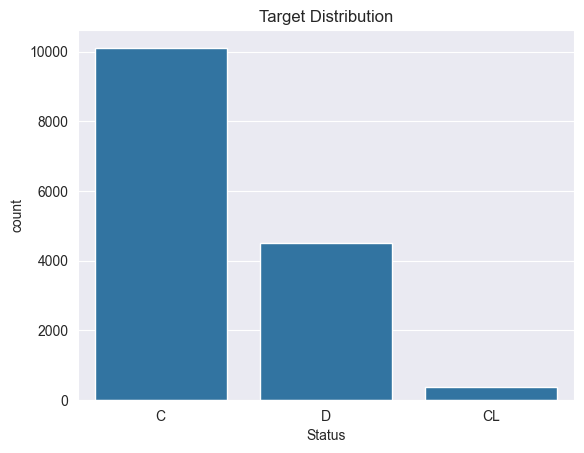

In [6]:

# ------------------------------------------------------------
# 4. BASIC EDA
# ------------------------------------------------------------
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

In [7]:

# ------------------------------------------------------------
# 5. FEATURE TYPES
# ------------------------------------------------------------
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [8]:

# ------------------------------------------------------------
# 6. MISSING VALUE HANDLING (TRAIN STATS ONLY)
# ------------------------------------------------------------
for col in num_cols:
    med = X[col].median()
    X[col].fillna(med, inplace=True)
    X_test[col].fillna(med, inplace=True)

for col in cat_cols:
    mode = X[col].mode()[0]
    X[col].fillna(mode, inplace=True)
    X_test[col].fillna(mode, inplace=True)

In [9]:

# ------------------------------------------------------------
# 7. OUTLIER HANDLING (IQR CAPPING)
# ------------------------------------------------------------
for col in num_cols:
    Q1, Q3 = X[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    X[col] = np.clip(X[col], low, high)
    X_test[col] = np.clip(X_test[col], low, high)

In [10]:

# ------------------------------------------------------------
# 8. CATEGORICAL ENCODING (ROBUST)
# ------------------------------------------------------------
ordinal_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

In [11]:

# ------------------------------------------------------------
# 9. TARGET ENCODING
# ------------------------------------------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

class_names = label_encoder.classes_
print("Encoded classes:", class_names)

Encoded classes: ['C' 'CL' 'D']


In [12]:

# ------------------------------------------------------------
# 10. TRAIN / VALIDATION SPLIT
# ------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [13]:

# ------------------------------------------------------------
# 11. MODELS (OPTIMIZED FOR ≤ 5000 ROWS)
# ------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(
        multi_class="multinomial",
        max_iter=1000
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=10,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2),
        n_estimators=200,
        learning_rate=0.3,
        random_state=42
    )
}

In [ ]:

# ------------------------------------------------------------
# 12. MODEL SELECTION (MACRO F1)
# ------------------------------------------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    f1 = f1_score(y_val, val_pred, average="macro")
    results.append([name, f1])

results_df = pd.DataFrame(results, columns=["Model", "Val_F1"])
print(results_df)

best_model_name = results_df.sort_values(
    "Val_F1", ascending=False
).iloc[0]["Model"]

final_model = models[best_model_name]
print("\nSelected model:", best_model_name)

In [ ]:

# ------------------------------------------------------------
# 13. TRAIN FINAL MODEL ON FULL DATA
# ------------------------------------------------------------
final_model.fit(X, y_encoded)

In [ ]:

# ------------------------------------------------------------
# 14. PREDICT PROBABILITIES ON TEST
# ------------------------------------------------------------
proba = final_model.predict_proba(X_test)

Train shape: (15000, 20)
Test shape : (10000, 19)
Target column: Status
Classes: ['C' 'D' 'CL']


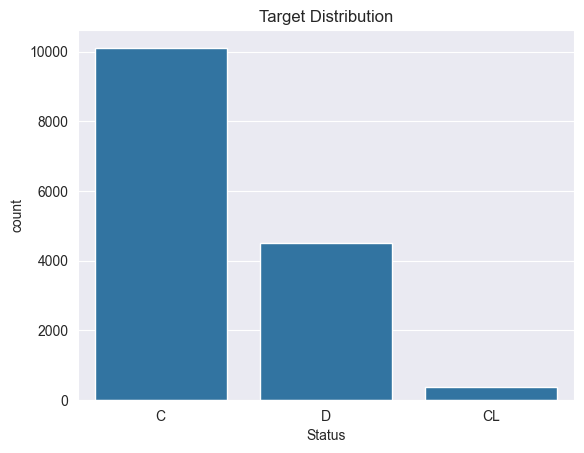

Encoded classes: ['C' 'CL' 'D']
                 Model    Val_F1
0  Logistic Regression  0.492604
1        Random Forest  0.550596
2    Gradient Boosting  0.645784
3             AdaBoost  0.562151

Selected model: Gradient Boosting

submission.csv created successfully
      id         C        CL         D
0  15000  0.907865  0.003694  0.088441
1  15001  0.971825  0.003319  0.024857
2  15002  0.921286  0.008563  0.070151
3  15003  0.083975  0.018710  0.897315
4  15004  0.943075  0.006440  0.050485


In [1]:

# ------------------------------------------------------------
# 15. CREATE KAGGLE SUBMISSION (ID + CLASS PROBABILITIES)
# ------------------------------------------------------------
submission = pd.DataFrame(
    proba,
    columns=class_names
)

submission.insert(0, id_col, test_ids)

submission.to_csv("submission.csv", index=False)

print("\nsubmission.csv created successfully")
print(submission.head())
# ------------------------------------------------------------
# 15. CREATE KAGGLE SUBMISSION (ID + CLASS PROBABILITIES)
# ------------------------------------------------------------

# Create submission
# submission = pd.DataFrame(proba, columns=label_encoder.classes_)
# submission.insert(0, "id", test_ids)
#
# Reorder columns as per Kaggle requirement
# correct_order = [
#     "Q1_premium_fresh",
#     "Q2_fresh",
#     "Q3_export_grade",
#     "Q4_dessert",
#     "Q5_juice_high",
#     "Q6_juice_low",
#     "Q7_processing",
#     "Q8_local_sale",
#     "Q9_feed",
#     "Q10_waste"
# ]
#
# submission = submission[["id"] + correct_order]
#
# submission.to_csv("submission.csv", index=False)
# submission.head()

# status case
# class_names = le.classes_  # use label encoder mapping
# submission = pd.DataFrame(y_final, columns=[f"Status_{cls}" for cls in class_names])
# submission.insert(0, 'id', test_id)
# submission.to_csv("submission4.csv", index=False)
# print("\n✅ Submission file created successfully!")
# print(submission.head())